# Import Modules

In [17]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
%matplotlib inline

# Structure Design

## Activation Functions Definition

In [18]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))


def relu(z, leak_grad=1e-8):
    return np.maximum(leak_grad*z, z)


def relu_derivative(z, leak_grad=1e-8):
    return np.where(z <= 0, leak_grad, 1)


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def tanh_derivative(z):
    return 1 - tanh(z)**2

In [19]:
activation_functions_dict = {'sigmoid': (sigmoid, sigmoid_derivative),
                             'relu': (relu, relu_derivative),
                             'tanh': (tanh, tanh_derivative)}

## Layer Namespace Definition

In [20]:
class LayerNamespace(object):
    pass

## Structure Class Definition

In [21]:
class ModelStructure(object):
    def __init__(self):
        self.__layers = []

    def add_input_layer(self, input_features: int):
        assert len(self.__layers) == 0, 'Add input layer before other layers'
        assert type(input_features) == int, 'Enter integer number'
        layer_0 = LayerNamespace()
        layer_0.units_number = input_features
        self.__layers.append(layer_0)

    def add_layer(self, units_number: int, activation_function_name: str,
                  keep_prob=1):
        assert type(units_number) == int, 'Enter integer number'
        assert len(self.__layers) > 0, 'First add input layer'

        try:
            layer = LayerNamespace()
            valid_key = activation_function_name.lower()
            layer.activation_function = activation_functions_dict[valid_key][0]
            layer.activation_function_derivative = activation_functions_dict[valid_key][1]
            layer.units_number = units_number
            layer.keep_prob = keep_prob
            self.__layers.append(layer)
        except KeyError as error:
            message = 'Valid activation functions: '
            message += ', '.join(activation_functions_dict.keys())
            raise KeyError(f'{error} ({message})')

        return True

    @property
    def layers(self):
        assert len(self.__layers) > 1, 'At least nsert one layer'
        return self.__layers

    def summary(self):
        print(f'Input Features: {self.layers[0].units_number}')
        total_parameters = 0
        pre_units = self.layers[0].units_number
        for i, layer in enumerate(self.layers[1:]):
            weights = layer.units_number * pre_units
            biases = layer.units_number
            message_parts = [f'Layer #{i+1}:',
                             f'{layer.units_number}',
                             f'{layer.activation_function.__name__}',
                             f'units with {weights} weights and',
                             f'{biases} biases']
            print(' '.join(message_parts))
            pre_units = layer.units_number
            total_parameters += (weights+biases)
        print(f'Total Parameters: {total_parameters}')

# Computation

## Tools

### Initializer

In [22]:
def initialize(layers: list):
    result = []
    previous_layer = layers[0]
    for layer in layers[1:]:
        shape = (layer.units_number,
                 previous_layer.units_number)
        # On weight initialization in deep neural networks
        scale_dict = {'relu': np.sqrt(2/shape[1]),
                      'tanh': np.sqrt(1/shape[1]),
                      'sigmoid': np.sqrt((3.6**2)/shape[1])}
        func_name = layer.activation_function.__name__
        layer.W = np.random.randn(
            shape[0], shape[1]) * scale_dict[func_name]

        layer.b = np.zeros((shape[0], 1))
        result.append(layer)
        previous_layer = layer
    return result

### Mini Batch Generator

In [23]:
def mini_batch_generator(x: np.ndarray, y: np.ndarray, batch_size: int):
    assert x.shape[1] == y.shape[1]
    m = x.shape[1]
    random_indice = np.random.permutation(m)
    shuffled_x = x[:, random_indice]
    shuffled_y = y[:, random_indice]

    div = divmod(m, batch_size)
    for i in range(div[0]):
        x_mini_batch = shuffled_x[:, i*batch_size:(i+1)*batch_size]
        x_mini_batch = x_mini_batch.reshape(x.shape[0], batch_size)

        y_mini_batch = shuffled_y[:, i*batch_size:(i+1)*batch_size]
        y_mini_batch = y_mini_batch.reshape(y.shape[0], batch_size)

        yield x_mini_batch, y_mini_batch

    if div[1]:
        x_mini_batch = shuffled_x[:, div[0]*batch_size:]
        x_mini_batch = x_mini_batch.reshape(x.shape[0], div[1])

        y_mini_batch = shuffled_y[:, div[0]*batch_size:]
        y_mini_batch = y_mini_batch.reshape(y.shape[0], div[1])

        yield x_mini_batch, y_mini_batch

### Metric Calculators

In [24]:
def predict(model_output):
    prediction = np.where(model_output > 0.5, 1, 0)
    return prediction


def accuracy(prediction, expected):
    assert prediction.shape == expected.shape
    assert prediction.shape[0] == 1
    m = expected.shape[1]
    accuracy = np.sum(prediction == expected)/m
    return accuracy

### Metric Visualization

In [25]:
def print_metrics(interval=100):
    def result_function(epoch, metrics):
        if (epoch == 1) or (epoch % interval == 0):
            cost = metrics['costs'][-1]
            accuracy = metrics['accuracies'][-1]*100
            message_parts = [f'Epoch #{epoch:0>4}',
                             f'Cost: {cost:.4f}',
                             f'Accuracy: {accuracy:.2f}%']

            if metrics['validation_costs']:
                validation_cost = metrics['validation_costs'][-1]
                validation_accuracy = metrics['validation_accuracies'][-1]*100
                message_parts.append(
                    f'Validation Cost: {validation_cost:.4f}')
                message_parts.append(
                    f'Validation Accuracy: {validation_accuracy:.2f}%')

            print(' | '.join(message_parts))
    return result_function

In [26]:
def plot_metrics(metrics: dict, interval=100):
    cost = metrics['costs']
    accuracy = metrics['accuracies']
    validation_cost = metrics['validation_costs']
    validation_accuracies = metrics['validation_accuracies']

    fig, axes = plt.subplots(2, 1)

    axes[0].plot(cost[::interval], label='Cost')
    axes[0].plot(validation_cost[::interval], label='Validation Cost')
    axes[0].set_ylabel('Cost')
    axes[0].legend()

    axes[1].plot(accuracy[::interval], label='Accuracy')
    axes[1].plot(validation_accuracies[::interval],
                 label='Validation Accuracy')
    axes[1].set_ylabel(f'Accuracy')
    axes[1].legend()

    fig.suptitle(f'iterations (per {interval} epochs)')
    fig.tight_layout()
    fig.set_size_inches(8, 8)
    plt.show()

## Cost Functions

In [27]:
def cross_entropy_cost(Y, Y_hat, epsilon=1e-4):
    assert Y.shape == Y_hat.shape, f'{Y.shape} != {Y_hat.shape}'
    m = Y.shape[1]  # number of examples
    cost = (-1/m) * (np.dot(Y, np.log(Y_hat+epsilon).T) +
                     np.dot((1-Y), np.log(1-Y_hat+epsilon).T))
    return cost.item()


def cross_entropy_derivative(Y, Y_hat, epsilon=1e-4):
    return ((1-Y)/(1-Y_hat+epsilon)) - (Y/Y_hat+epsilon)


def get_regularization_cost(layers: list, m: int, lambda_: float) -> float:
    cost = 0
    for layer in layers:
        cost += np.sum(np.square(layer.W))
    cost *= (1/m) * (lambda_/2)
    return cost

## Optimizers

### Optimizer Superclass

In [28]:
class Optimizer(object):
    def initiate_parameters(self, layers: list):
        pass
    def update_parameters(self, layers: list):
        pass
    def update_optimizer(self, metrics: dict):
        pass

### Gradient Descent

In [29]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layers: list):
        for layer in layers:
            layer.W = layer.W - self.learning_rate*layer.dW
            layer.b = layer.b - self.learning_rate*layer.db
        return True

### Momentum

In [30]:
class Momentum(Optimizer):
    def __init__(self, learning_rate, beta):
        self.learning_rate = learning_rate
        self.beta = beta

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.V_dW = np.zeros(layer.W.shape)
            layer.V_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.V_dW = self.beta*layer.V_dW + (1-self.beta)*layer.dW
            layer.V_db = self.beta*layer.V_db + (1-self.beta)*layer.db
            
            layer.W = layer.W - self.learning_rate*layer.V_dW
            layer.b = layer.b - self.learning_rate*layer.V_db
        return True

### RMSprop

In [31]:
class RMSprop(Optimizer):
    def __init__(self, learning_rate, beta=0.9):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = 1e-8

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.S_dW = np.zeros(layer.W.shape)
            layer.S_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.S_dW = self.beta*layer.S_dW + (1-self.beta)*np.square(layer.dW)
            layer.S_db = self.beta*layer.S_db + (1-self.beta)*np.square(layer.db)
            
            layer.W = layer.W - self.learning_rate*(layer.dW/(np.sqrt(layer.S_dW)+self.epsilon))
            layer.b = layer.b - self.learning_rate*(layer.db/(np.sqrt(layer.S_db)+self.epsilon))
        return True

### Adam

In [32]:
class Adam(Optimizer):
    def __init__(self, learning_rate, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = 1e-8
        self.counter = 0

    def initiate_parameters(self, layers: list):
        self.counter = 0
        for layer in layers:
            layer.V_dW = np.zeros(layer.W.shape)
            layer.V_db = np.zeros(layer.b.shape)
            layer.S_dW = np.zeros(layer.W.shape)
            layer.S_db = np.zeros(layer.b.shape)
            
            layer.V_corrected_dW = np.zeros(layer.W.shape)
            layer.V_corrected_db = np.zeros(layer.b.shape)
            layer.S_corrected_dW = np.zeros(layer.W.shape)
            layer.S_corrected_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.V_dW = self.beta_1*layer.V_dW + (1-self.beta_1)*layer.dW
            layer.V_db = self.beta_1*layer.V_db + (1-self.beta_1)*layer.db
            layer.S_dW = self.beta_2*layer.S_dW + (1-self.beta_2)*np.square(layer.dW)
            layer.S_db = self.beta_2*layer.S_db + (1-self.beta_2)*np.square(layer.db)
            
            # Apply bias correction
            momentum_correction = 1/(1-self.beta_1**(self.counter+1))
            rmsprop_correction = 1/(1-self.beta_2**(self.counter+1))

            layer.V_corrected_dW = layer.V_dW*momentum_correction
            layer.V_corrected_db = layer.V_db*momentum_correction
            layer.S_corrected_dW = layer.S_dW*rmsprop_correction
            layer.S_corrected_db = layer.S_db*rmsprop_correction
        
            layer.W = layer.W - self.learning_rate*(layer.V_corrected_dW/(np.sqrt(layer.S_corrected_dW)+self.epsilon))
            layer.b = layer.b - self.learning_rate*(layer.V_corrected_db/(np.sqrt(layer.S_corrected_db)+self.epsilon))
        self.counter += 1
        return True

### Mechanic Rules

In [33]:
class MechanicRules(Optimizer):
    def __init__(self, learning_rate, g=9.81):
        self.learning_rate = learning_rate
        self.g = g
        self.epsilon = 1e-8

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_hat_W = np.zeros(layer.W.shape)
            layer.v_hat_b = np.zeros(layer.b.shape)
            
            layer.a_hat_W = np.zeros(layer.W.shape)
            layer.a_hat_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            s_W = 1 / (np.sqrt(1+np.square(layer.dW))+self.epsilon)
            s_b = 1 / (np.sqrt(1+np.square(layer.db))+self.epsilon)
            
            layer.W = (-0.5*(self.g*layer.dW*s_W + layer.a_hat_W)*(self.learning_rate**2) + layer.v_hat_W*self.learning_rate + layer.W)*s_W
            layer.b = (-0.5*(self.g*layer.db*s_b + layer.a_hat_b)*(self.learning_rate**2) + layer.v_hat_b*self.learning_rate + layer.b)*s_b
            
            layer.v_hat_W = -(self.g*layer.dW*s_W+layer.a_hat_W)*self.learning_rate + layer.v_hat_W
            layer.v_hat_b = -(self.g*layer.db*s_b+layer.a_hat_b)*self.learning_rate + layer.v_hat_b
        return True

### Gravity

In [34]:
class Gravity(Optimizer):
    def __init__(self, learning_rate, g=9.81):
        self.learning_rate = learning_rate
        self.g = g
        self.epsilon = 1e-8

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c1_W = (-self.g*layer.dW) / (1+np.square(layer.dW)+self.epsilon)
            c2_W = 1 / (np.sqrt(1+np.square(layer.dW))+self.epsilon)
            layer.v_W = c1_W*self.learning_rate + c2_W*layer.v_W
                        
            c1_b = (-self.g*layer.db) / (1+np.square(layer.db)+self.epsilon)
            c2_b = 1 / (np.sqrt(1+np.square(layer.db))+self.epsilon)
            layer.v_b = c1_b*self.learning_rate + c2_b*layer.v_b
            
            layer.W = self.learning_rate*layer.v_W + layer.W
            layer.b = self.learning_rate*layer.v_b + layer.b

        return True

## Main Model Class

In [35]:
class Classifier(object):
    def __init__(self, model_structure: ModelStructure):
        self.input_features = model_structure.layers[0].units_number
        self.layers = initialize(model_structure.layers)
        self.cost_function = cross_entropy_cost
        self.cost_function_derivative = cross_entropy_derivative
        self.trained_epochs = 0

    def feed_forward(self, X: np.ndarray):
        assert X.shape[0] == self.input_features
        A_prev = X
        for layer in self.layers:
            Z = np.dot(layer.W, A_prev) + layer.b
            A = layer.activation_function(Z)
            A_prev = A
        Y_hat = A_prev
        return Y_hat

    def feed_forward_train(self, X: np.ndarray):
        assert X.shape[0] == self.input_features
        A_prev = X
        for layer in self.layers:
            layer.A_previous = A_prev
            layer.Z = np.dot(layer.W, A_prev) + layer.b
            A_raw = layer.activation_function(
                layer.Z)  # Before applying dropout
            layer.D = np.random.rand(
                *A_raw.shape) < layer.keep_prob  # Dropout Mask
            layer.A = (A_raw * layer.D) / layer.keep_prob
            A_prev = layer.A
        Y_hat = A_prev
        return Y_hat

    def back_propagate(self, cost_derivative, lambda_):
        dA_prev = cost_derivative
        m = self.layers[0].Z.shape[1]  # number of examples
        for layer in self.layers[::-1]:
            layer.dA = (dA_prev*layer.D) / layer.keep_prob
            layer.dZ = layer.dA * layer.activation_function_derivative(layer.Z)
            layer.dW = (1/m) * np.dot(layer.dZ,
                                      layer.A_previous.T) + (lambda_/m)*layer.W
            layer.db = 1/m * np.sum(layer.dZ, axis=1, keepdims=True)
            dA_prev = np.dot(layer.W.T, layer.dZ)
        return True

    def fit_minibatch(self, mini_X, mini_Y, lambda_, optimizer):
        mini_Y_hat = self.feed_forward_train(mini_X)
        cost_derivative = self.cost_function_derivative(mini_Y, mini_Y_hat)
        self.back_propagate(cost_derivative, lambda_)
        optimizer.update_parameters(self.layers)
        return True

    def fit(self, X, Y, epochs, batch_size, optimizer,
            lambda_=0,
            validation_data=None,
            metrics_printer=None):
        
        # Assert Shapes
        assert X.shape[1] == Y.shape[1]        
        m = X.shape[1]
        if validation_data:
            assert type(validation_data) == tuple
            assert type(validation_data[0]) == np.ndarray
            assert type(validation_data[1]) == np.ndarray
            assert validation_data[0].shape[0] == X.shape[0]
            assert validation_data[1].shape[0] == Y.shape[0]
            assert validation_data[0].shape[1] == validation_data[1].shape[1]

        metrics = {
            'costs': [],
            'accuracies': [],
            'validation_costs': [],
            'validation_accuracies': [],
            'learning_rate': []
        }
        optimizer.initiate_parameters(self.layers)
        for _ in range(1, epochs+1):            
            mini_batchs = mini_batch_generator(X, Y, batch_size)
            for mini_X, mini_Y in mini_batchs:
                self.fit_minibatch(mini_X, mini_Y, lambda_, optimizer)

            regularization_cost = get_regularization_cost(self.layers, m,
                                                          lambda_)

            train_Y_hat = self.feed_forward(X)
            train_cost = self.cost_function(Y, train_Y_hat)
            train_cost += regularization_cost
            train_prediction = predict(train_Y_hat)
            train_accuracy = accuracy(train_prediction, Y)
            metrics['costs'].append(train_cost)
            metrics['accuracies'].append(train_accuracy)

            if validation_data:
                validation_X = validation_data[0]
                validation_Y = validation_data[1]
                validation_Y_hat = self.feed_forward(validation_X)
                validation_cost = self.cost_function(validation_Y,
                                                     validation_Y_hat) 
                validation_cost += regularization_cost
                validation_prediction = predict(validation_Y_hat)
                validation_accuracy = accuracy(validation_prediction,
                                               validation_Y)
                metrics['validation_costs'].append(validation_cost)
                metrics['validation_accuracies'].append(validation_accuracy)

            self.trained_epochs += 1

            if metrics_printer:
                metrics_printer(self.trained_epochs, metrics)
                
            optimizer.update_optimizer(metrics)
        return metrics

# Test (Binary Classification on Cat vs Dogs Dataset)

In [36]:
def get_cats_vs_dogs_dataset(cats_array_path,
                             dogs_array_path,
                             seed=42, test_size = 0.3):
    cats = np.load(cats_array_path)
    flatten_cats = cats.reshape(cats.shape[0], -1).T    
    dogs = np.load(dogs_array_path)
    flatten_dogs = dogs.reshape(dogs.shape[0], -1).T
    cats_labels = np.ones((1, flatten_cats.shape[1]))
    dogs_labels = np.zeros((1, flatten_dogs.shape[1]))
    X = np.concatenate((flatten_cats, flatten_dogs), axis=1)
    Y = np.concatenate((cats_labels, dogs_labels), axis=1)    
    
    m = X.shape[1]
    np.random.seed(seed)
    random_indice = np.random.permutation(m)
    shuffled_X = X[:, random_indice]
    shuffled_Y = Y[:, random_indice]
    
    test_size = int(m*test_size)
    train_size = m - test_size
    train_X = shuffled_X[:, 0:train_size]
    train_Y = shuffled_Y[:, 0:train_size]
    test_X = shuffled_X[:, train_size:]
    test_Y = shuffled_Y[:, train_size:]
    return train_X, train_Y, test_X, test_Y

In [42]:
from pathlib import Path

In [49]:
cats_path = Path.joinpath(Path('datasets'),Path('cats_vs_dogs'),Path('cats_array.npy'))
dogs_path = Path.joinpath(Path('datasets'),Path('cats_vs_dogs'),Path('dogs_array.npy'))
cats_path.exists()

True

In [46]:
X_train, Y_train, X_test, Y_test = get_cats_vs_dogs_dataset(cats_path, dogs_path)
print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of Y_train: {Y_train.shape}')
print(f'Shape of X_test: {X_test.shape}')
print(f'Shape of Y_test: {Y_test.shape}')

Shape of X_train: (12288, 17451)
Shape of Y_train: (1, 17451)
Shape of X_test: (12288, 7479)
Shape of Y_test: (1, 7479)


[1.]


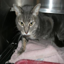

In [38]:
number = 13
print(Y_train[:, number])
PIL.Image.fromarray(X_train[:, number].reshape((64, 64, 3)))

[0.]


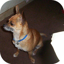

In [39]:
number = 7
print(Y_test[:, number])
PIL.Image.fromarray(X_test[:, number].reshape((64, 64, 3)))

In [ ]:
structure = ModelStructure()
structure.add_input_layer(test_x.shape[0])
structure.add_layer(1000, 'relu', keep_prob=1)
structure.add_layer(1000, 'relu', keep_prob=1)
structure.add_layer(1, 'sigmoid')
structure.summary()

In [ ]:
# del model
model = Classifier(structure)

gd_optimizer = GradientDescent(learning_rate=0.01)

momentum_optimizer = Momentum(learning_rate=0.01, beta=0.9)
rmsprop_optimizer = RMSprop(learning_rate=0.0002, beta=0.999)
adam_optimizer = Adam(learning_rate=0.001)

gravity = Gravity(learning_rate=0.01, g=10)

epochs=50
metrics = model.fit(X_train, Y_train, epochs, optimizer=gravity,
                    batch_size=128, validation_data=(X_test, Y_test),
                    lambda_=0, metrics_printer=print_metrics(1))

## Plot Cost

In [ ]:
plt.xkcd()
plot_metrics(metrics) 